# Project: AB Testing

## Overview and Statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
website_data = pd.read_csv('ab_data (1).csv')
website_data.head()

,country,group,converted
0,UK,control,0
1,US,treatment,1
2,UK,treatment,0
3,UK,control,0
4,UK,treatment,0


In [3]:
website_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69889 entries, 0 to 69888
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    69889 non-null  object
 1   group      69889 non-null  object
 2   converted  69889 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [4]:
website_data['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [5]:
website_data['group'].unique()

array(['control', 'treatment'], dtype=object)

### Do we have equal amount of users in each group?

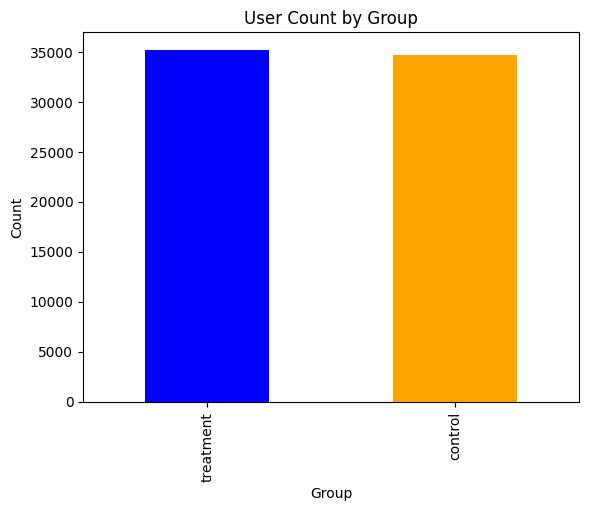

In [6]:
group_counts = website_data['group'].value_counts()
group_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Group')
plt.ylabel('Count')
plt.title('User Count by Group')
plt.show()

In [7]:
print(website_data.query('group == "treatment"').value_counts().sum())
print(website_data.query('group == "control"').value_counts().sum())

35211
34678


Both groups are almost equal.

### What country most are most of our users from?

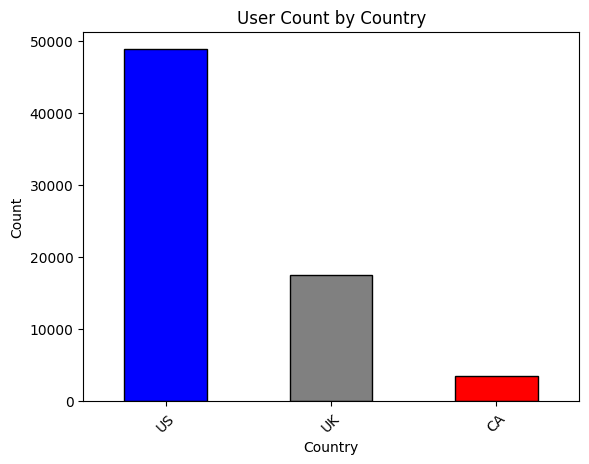

In [22]:
country_counts = website_data['country'].value_counts()
country_counts.plot(kind='bar', edgecolor='black', color=['blue', 'gray', 'red'])
plt.xticks(rotation=45)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('User Count by Country')
plt.show()

In [9]:
country_counts['US'] / country_counts.sum() * 100

np.float64(69.89655024395827)

69.9% of website users are from US

### What is the conversion rate?

In [10]:
website_data['converted'].mean()*100

np.float64(13.047832992316389)

13% of our users regardless of group are converted

### Given that an individual was in the control group, what is the probability they converted? 

In [11]:
website_data.query('group == "control"')['converted'].mean()*100

np.float64(10.52540515600669)

10.5%

### Given that an individual was in the treatment group, what is the probability they converted? 

In [12]:
website_data.query('group == "treatment"')['converted'].mean()*100

np.float64(15.532078043793133)

15.5%

### What country has highest conversion rates?

In [13]:
print(website_data.query('country == "US"')['converted'].mean() * 100)
print(website_data.query('country == "UK"')['converted'].mean() * 100)
print(website_data.query('country == "CA"')['converted'].mean() * 100)

13.277379733879222
12.512107572218106
12.52866972477064


C:\Users\TECHNICAL\AppData\Local\Temp\ipykernel_21348\4115997382.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='country', y='converted', data=website_data, ci=None)


<Axes: title={'center': 'Country vs Converted'}, xlabel='country', ylabel='converted'>

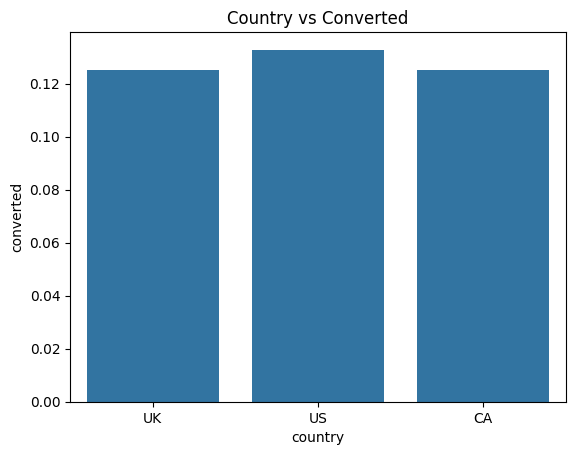

In [14]:
plt.title('Country vs Converted')
sns.barplot(x='country', y='converted', data=website_data, ci=None)

US has highest conversion rate of 13.3%

## Cleaning And Preparing

In [15]:
website_data['ab_page'] = pd.get_dummies(website_data['group'])['treatment'].astype(int)

In [16]:
website_data.head()

,country,group,converted,ab_page
0,UK,control,0,0
1,US,treatment,1,1
2,UK,treatment,0,1
3,UK,control,0,0
4,UK,treatment,0,1


We will need the ab_page column soon for regression and machine learning it's just group column but in boolean datatype.

In [17]:
website_data[['US', 'UK']] = pd.get_dummies(website_data['country'])[['US', 'UK']].astype(int)

In [18]:
website_data.head()

,country,group,converted,ab_page,US,UK
0,UK,control,0,0,0,1
1,US,treatment,1,1,1,0
2,UK,treatment,0,1,0,1
3,UK,control,0,0,0,1
4,UK,treatment,0,1,0,1


Same as above but we didn't include canada because we will use canada as a baseline.

## Hypothesis Testing

### Hypothesis Statement

Let's create our hypothesis statement!

Null Hypothesis (H₀): The conversion rate for the control group is equal to the conversion rate for the treatment group.

Alternative Hypothesis (H₁): The conversion rate for the control group is not equal to the conversion rate for the treatment group.

$$ H_0: p_{\text{control}} = p_{\text{treatment}} $$

$$ H_1: p_{\text{control}} \ne p_{\text{treatment}} $$

### Significance Level

We will choose a significance level of 0.05 which means there is a 5% we were wrong if we reject the null hypothesis.

$\alpha$ = 0.05

### Proportion z-test

In [19]:
#define important variables for our hypothesis test
converted_control = website_data.query('group == "control"')['converted'].mean()
converted_treatment = website_data.query('group == "treatment"')['converted'].mean()
n_control = website_data.query('group == "control"').shape[0]
n_treatment = website_data.query('group == "treatment"').shape[0]

In [20]:
#Number of conversions (successes) in each group
successes = [converted_control, converted_treatment]

#Total observations (sample size) in each group
nobs = [n_control, n_treatment]

#Run the two-proportion z-test
z_stat, p_value = sm.stats.proportions_ztest(successes, nobs)

print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")

Z-Statistic: -0.09419048359923778
P-Value: 0.9249578441539414


Based on the two-proportion z-test, the p-value (0.92) is far above the 0.05 significance level, indicating that we fail to reject the null hypothesis. Therefore, we do not have sufficient evidence to conclude that the treatment page leads to a different conversion rate compared to the control page.

## Regression

### Logistic Regression

In [21]:
#Create dummy variable for treatment group
website_data['intercept'] = 1

#Define independent variables (X) and dependent variable (y)
X = website_data[['intercept', 'ab_page']]
y = website_data['converted']

#Fit the logistic regression model
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit()


print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.384516
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                69889
Model:                          Logit   Df Residuals:                    69887
Method:                           MLE   Df Model:                            1
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                0.007175
Time:                        12:31:36   Log-Likelihood:                -26873.
converged:                       True   LL-Null:                       -27068.
Covariance Type:            nonrobust   LLR p-value:                 1.810e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.1402      0.017   -122.305      0.000      -2.174      -2.106
ab_page        0.4467      0.

#### Logistic Regression Results

##### Key Results:

- The coefficient for `ab_page` is **0.4467**, with a p-value < 0.0001.
- This suggests that being exposed to the treatment page has a statistically significant positive effect on the odds of conversion.

##### Odds Ratio:

We can convert the coefficient to an odds ratio:

$$ \text{Odds Ratio} = e^{0.4467} \approx 1.56 $$

This indicates that the odds of conversion increase by approximately **56%** for users who see the treatment page compared to the control page.

##### Conclusion:

While the earlier two-proportion z-test did not detect a significant difference, the logistic regression suggests that, when using all individual data points and accounting for large sample size, there is a statistically significant positive effect of the treatment page on conversion rates.